# CEO-Request

## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from IPython.display import Markdown as md

## Objective of this Notebook
I will analyze a dataset provided by an e-commerce marketplace called Olist to answer the CEO’s question:

❓ **How could Olist increase its profit?**

## About Olist (Brasil)

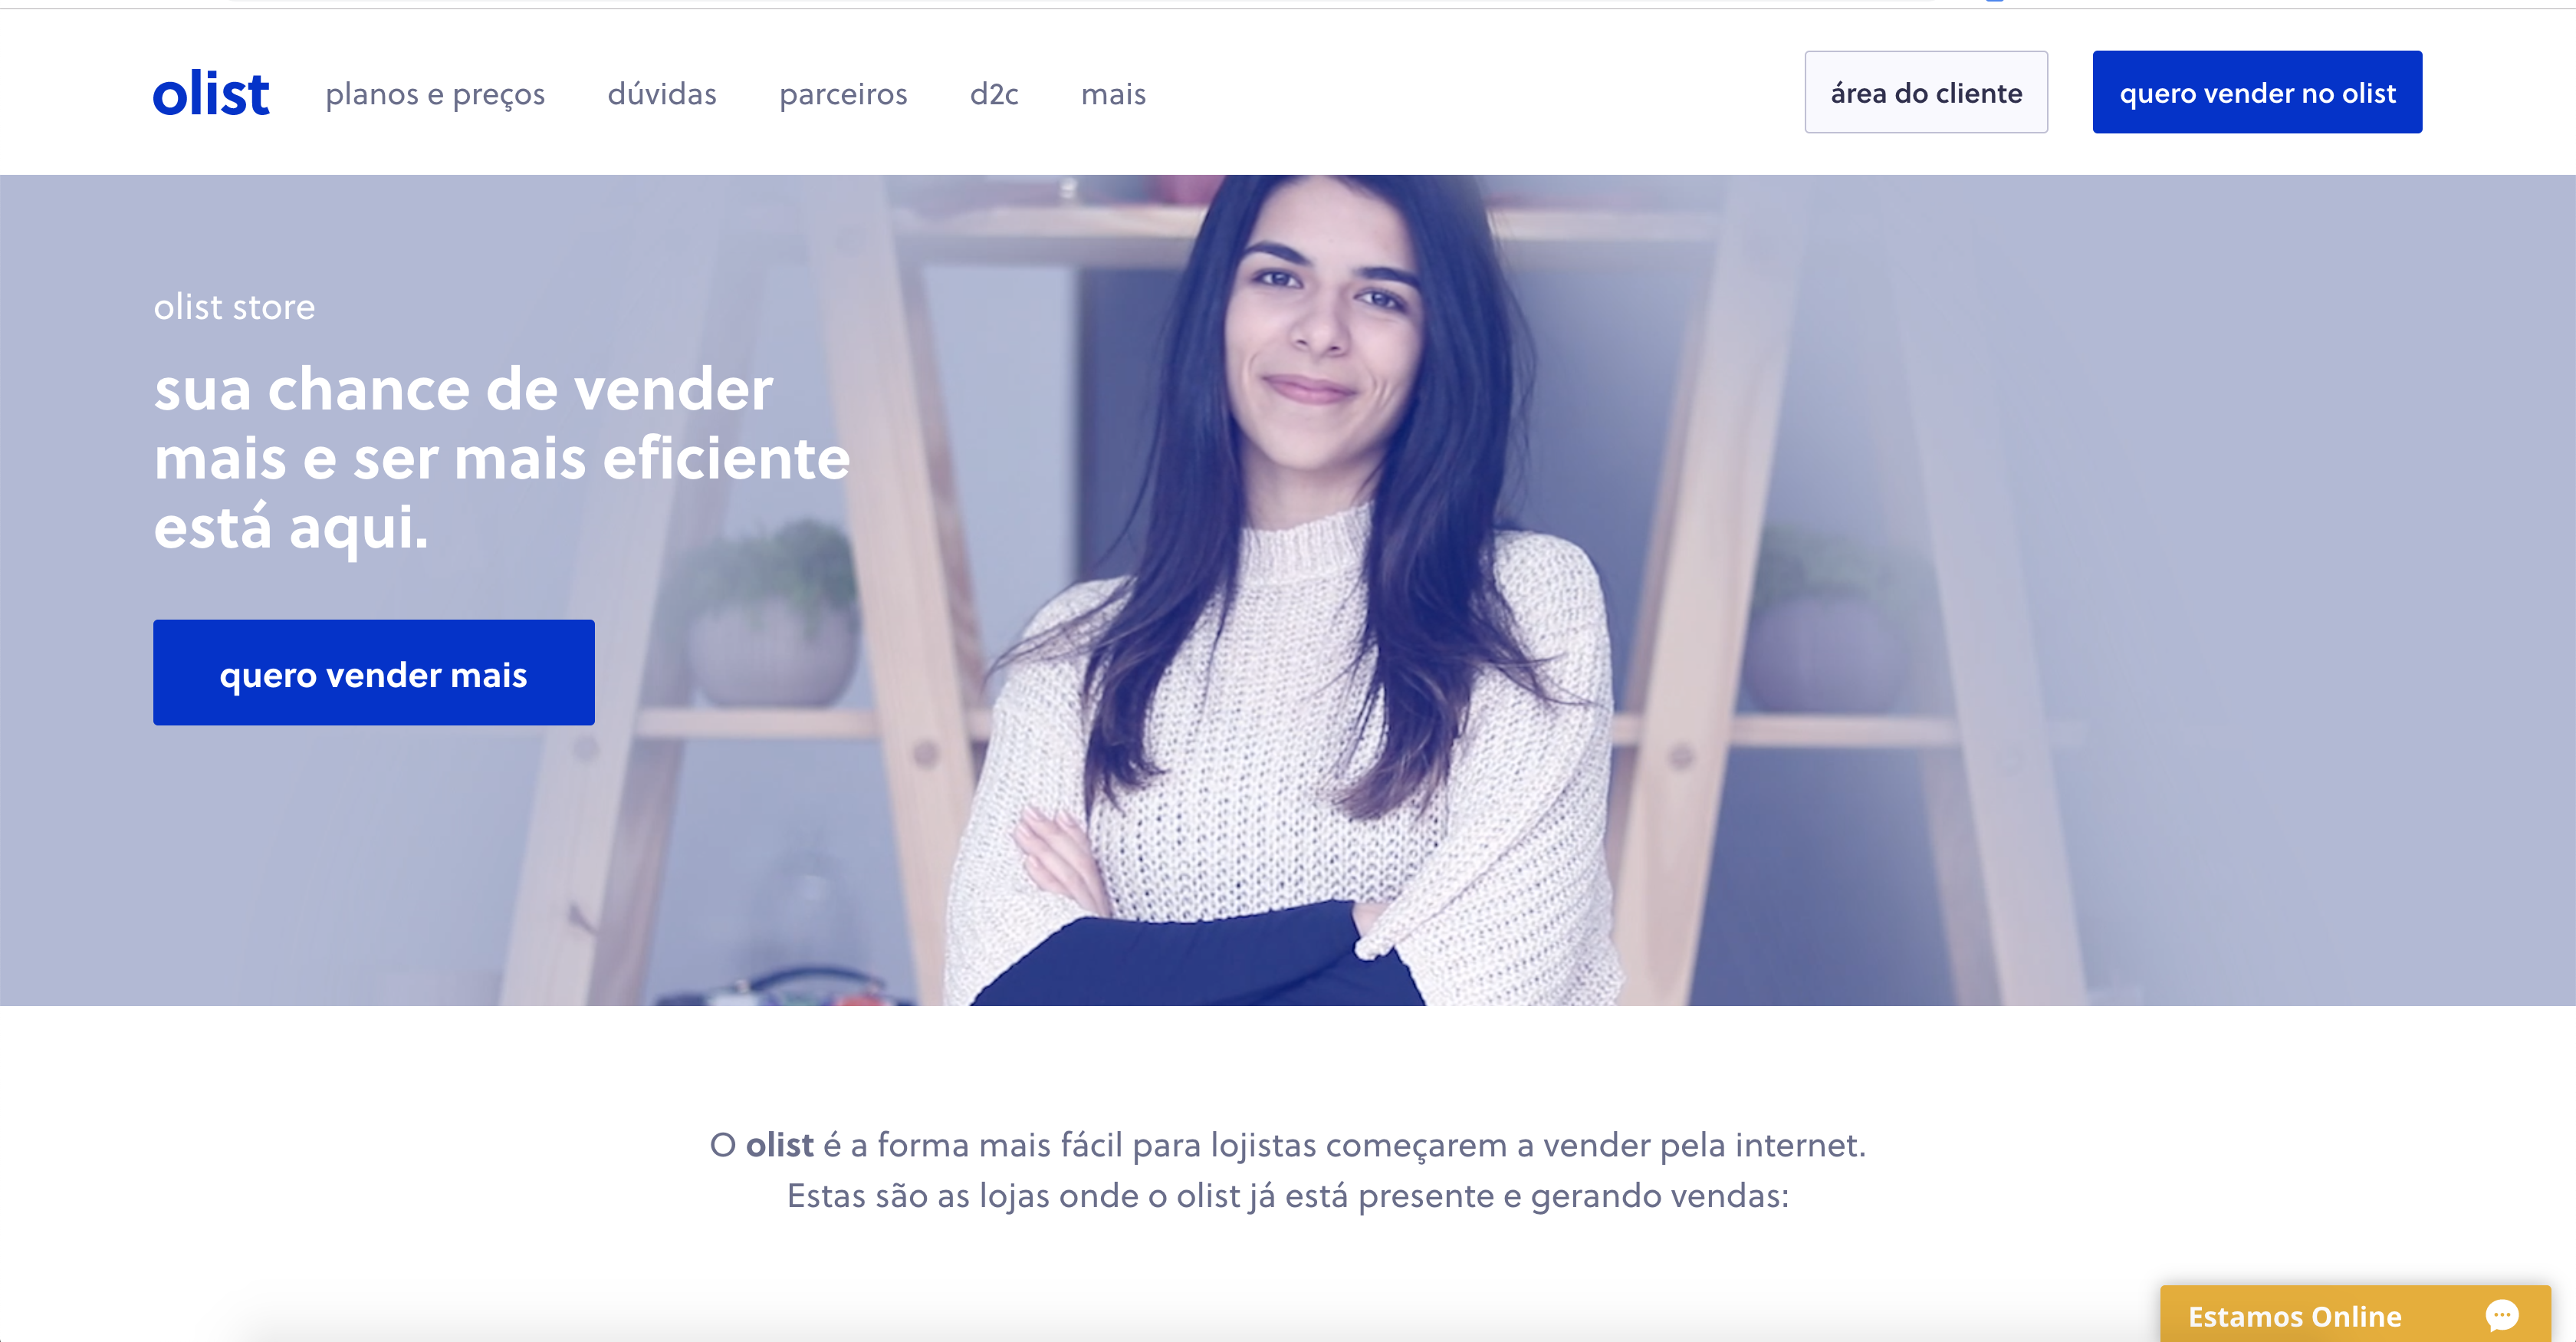

Olist is a leading e-commerce service that connects merchants to main marketplaces in Brazil.  
They provide a wide range of offers including inventory management, dealing with reviews and customer contacts to logistic services.

Olist charges sellers a monthly fee. This fee is progressive with the volume of orders.

Here are the seller and customer workflows:

**Seller:**

- Seller joins Olist
- Seller uploads products catalogue
- Seller gets notified when a product is sold
- Seller hands over an item to the logistic carrier  

👉 Note that multiple sellers can be involved in one customer order!

**Customer:**

- Browses products on the marketplace
- Purchases products from Olist.store
- Gets an expected date for delivery
- Receives the order
- Leaves a review about the order  

👉 A review can be left as soon as the order is sent, meaning that a customer can leave a review for a product he did not receive yet!

## 1. Summary of Problem Statement

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

### Revenues  
**Sales fees:**  
Olist takes a **10% cut** on the product price (excl. freight) of each order delivered.  
  
**Subscription fees:**  
Olist charges **80 BRL by month** per seller


### Costs
**Reputation costs**:  
*Estimated* per order with bad reviews (<= 3 stars)  

In the long run, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication.  
I will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost in BRL
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:**  
Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever joined the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  

Olist's data team gave me the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction impact the cost of the IT systems.  
💡 Square roots reflect scale-effects: IT-systems are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the other way around: 
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told me that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

## 2. Investigating underperforming Sellers

### 2.1 Data Preparation

For each `seller_id` I will compute, and accumulate since the beginning of Olist:
- the `revenues` the seller brings
- the `review_costs` associated with all the sellers bad reviews
- the resulting `profits` (revenues - costs)

Starting from the `Seller` class of my `utils` package:

I am going to update the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [2]:
root_path = os.path.join(os.getcwd(),'..')
if root_path not in sys.path:
    sys.path.append(root_path)

from utils.seller import Seller

seller_instance = Seller()
# Before updating the methods in the `utils/seller.py`
sellers = seller_instance.get_training_data()
sellers.head(3)

seller_id     seller_city seller_state  \
0  3442f8959a84dea7ee197c632cb2df15        campinas           SP   
1  d1b65fc7debc3361ea86b5f14c68d2e2      mogi guacu           SP   
2  ce3ad9de960102d0677a81f5d0bb7b2d  rio de janeiro           RJ   

   delay_to_carrier  wait_time     date_first_sale      date_last_sale  \
0               0.0  13.018588 2017-05-05 16:25:11 2017-08-30 12:50:19   
1               0.0   9.065716 2017-03-29 02:10:34 2018-06-06 20:15:21   
2               0.0   4.042292 2018-07-30 12:44:49 2018-07-30 12:44:49   

   months_on_olist  n_orders  quantity  quantity_per_order     sales  \
0              4.0         3         3               1.000    218.70   
1             14.0        40        41               1.025  11703.07   
2              0.0         1         1               1.000    158.00   

   share_of_one_stars  share_of_five_stars  review_score  cost_of_reviews  \
0            0.333333             0.333333          3.00              140   
1            0.050000             0.725000          4.55              240   
2            0.000000             1.000000          5.00                0   

    revenue    profit  
0   341.870   201.870  
1  2290.307  2050.307  
2    15.800    15.800

In [3]:
# After updating the methods in the `utils/seller.py`
sellers = seller_instance.get_training_data()
sellers.head(3)

seller_id     seller_city seller_state  \
0  3442f8959a84dea7ee197c632cb2df15        campinas           SP   
1  d1b65fc7debc3361ea86b5f14c68d2e2      mogi guacu           SP   
2  ce3ad9de960102d0677a81f5d0bb7b2d  rio de janeiro           RJ   

   delay_to_carrier  wait_time     date_first_sale      date_last_sale  \
0               0.0  13.018588 2017-05-05 16:25:11 2017-08-30 12:50:19   
1               0.0   9.065716 2017-03-29 02:10:34 2018-06-06 20:15:21   
2               0.0   4.042292 2018-07-30 12:44:49 2018-07-30 12:44:49   

   months_on_olist  n_orders  quantity  quantity_per_order     sales  \
0              4.0         3         3               1.000    218.70   
1             14.0        40        41               1.025  11703.07   
2              0.0         1         1               1.000    158.00   

   share_of_one_stars  share_of_five_stars  review_score  cost_of_reviews  \
0            0.333333             0.333333          3.00              140   
1            0.050000             0.725000          4.55              240   
2            0.000000             1.000000          5.00                0   

    revenue    profit  
0   341.870   201.870  
1  2290.307  2050.307  
2    15.800    15.800

### 2.2 Big picture: Insight into Olist Financials

#### Revenues

In [4]:
revenue_sales = sellers['sales'].sum() * 0.1
revenue_subscription = sellers['months_on_olist'].sum() * 80
revenue_total = sellers['revenue'].sum()

print(
    f'''
Sales Cut: {revenue_sales:.2f} BRL
Subscriptions: {revenue_subscription:.2f} BRL
---
Total Revenue: {revenue_total:.2f} BRL
''')


Sales Cut: 1355578.44 BRL
Subscriptions: 1430240.00 BRL
---
Total Revenue: 2785818.44 BRL



#### Costs

In [5]:
costs_reviews = sellers['cost_of_reviews'].sum()
costs_it = 500_000
costs_total = costs_reviews + costs_it

print(
    f'''
Review Cost: {costs_reviews:.2f} BRL
IT Cost: {costs_it:.2f} BRL
---
Total Costs: {costs_total:.2f} BRL
''')


Review Cost: 1618210.00 BRL
IT Cost: 500000.00 BRL
---
Total Costs: 2118210.00 BRL



#### Profits

In [6]:
# Gross Profit, before IT costs
profits_gross = sellers['profit'].sum()
print(f'Gross Profit (before IT Costs): {profits_gross:.2f} BRL')

Gross Profit (before IT Costs): 1167608.44 BRL


In [7]:
# Gross Profit, after IT costs
profits_net = profits_gross - costs_it
print(f'Gross Profit (after IT Costs): {profits_net:.2f} BRL')

Gross Profit (after IT Costs): 667608.44 BRL


In [8]:
fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative", "relative", "total", "relative", "total", "relative", "total"],
    x = ["Monthly subcriptions", "Sales fees", "Total Revenues", "Reviews costs", "Gross Profit", "It costs", "Net Profit"],
    textposition = "outside",
    y = [revenue_subscription, revenue_sales, 0, -costs_reviews, 0,-costs_it, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = {'text': "Olist Profit & Loss (BRL)",
                 'yanchor': 'top',
                 'xanchor': 'left',
                 'xref': 'paper',
                 'font': {'size': 36}},
        showlegend = False
)

fig.show()

### 2.3 What is an under-performing seller?

In [9]:
# Total number of sellers
n_sellers = sellers.shape[0]
# Number of sellers with negative profits
n_negative = sellers.query('profit <= 0').shape[0]
# % of sellers with negative profits
pct_negative = n_negative / n_sellers * 100
# Mean and median of sellers'profits
mean, med = sellers['profit'].mean(), sellers['profit'].median()
# .25 quantile
q25 = sellers['profit'].quantile(q=.25)
n_q25 = sellers.query(f'profit <= {q25}').shape[0]
# Min, Max of sellers'profits
min_, max_ = sellers['profit'].min(), sellers['profit'].max()

In [10]:
print(f"""
👉 There are {n_sellers} sellers on Olist

Insights on the profits they generate for Olist:

👉 {n_negative} ({pct_negative:,.1f}%) of them generate a negative profit.
👉 Profits across sellers from {min_:,.0f} to {max_:,.0f} BRL.
👉 The average profit per seller is {mean:,.2f} BRL.
👉 50% of sellers generate at least a profit of {med:,.2f} BRL.
👉 25% ({n_q25}) of sellers generate a profit inferior to {q25:,.2f} BRL.
""")



👉 There are 2967 sellers on Olist

Insights on the profits they generate for Olist:

👉 376 (12.7%) of them generate a negative profit.
👉 Profits across sellers from -21,520 to 18,068 BRL.
👉 The average profit per seller is 393.53 BRL.
👉 50% of sellers generate at least a profit of 254.37 BRL.
👉 25% (742) of sellers generate a profit inferior to 20.98 BRL.



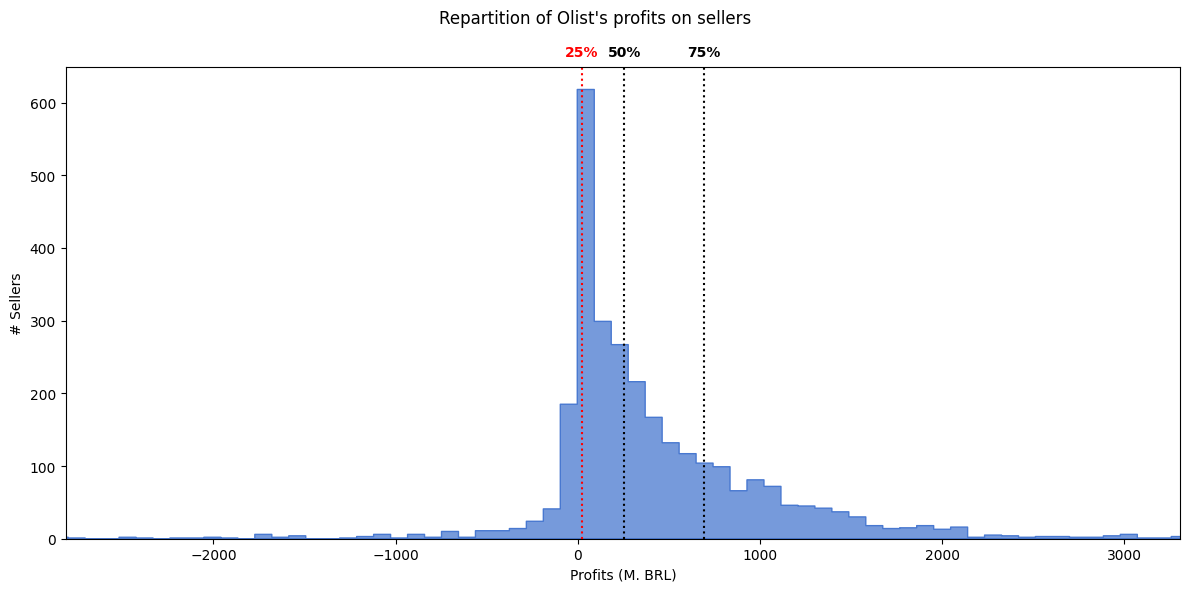

In [11]:
sns.set_palette('muted')

fig, ax = plt.subplots(figsize=(12, 6))

plt.suptitle(t="Repartition of Olist's profits on sellers")

sns.histplot(sellers['profit'],
             stat='count',
             element='step',
             ax=ax)

quantiles = sellers['profit'].quantile(q=[.01, .25, .5, .75, .99])

ax.set_xlim(quantiles.iloc[0], quantiles.iloc[-1])
ax.set_xlabel(xlabel='Profits (M. BRL)')
ax.set_ylabel(ylabel='# Sellers')

for p, q in quantiles.iloc[1:-1].items():
    c_ = 'black'
    if p == .25:
        c_ = 'red'
    ax.axvline(x=q,
               color=c_,
               ls=':')
    ax.text(x=q,
            y=ax.get_yticks()[-1] - 30,
            s=f'{p:.0%}',
            color=c_,
            ha='center',
            va='center',
            weight='bold')

fig.tight_layout();

### Interpretation
I estimate that removing the **742** sellers (25% of all sellers) that yielded a profit inferior to **20.98** BRL will result in an increased profit.  
The number of sellers to remove for the best outcome shall be further investigated.  
  
**Note:**  
Even more of the low-profit sellers could be considered as **under-performers**, however removing too many from the platform might have a negative impact, as the range and selection of products for sale will be reduced as well.

## 3. What-if Analysis

To analyze the impact of removing the worst sellers from Olist's marketplace, I will perform a **what-if analysis**.

❓ **What could Olist do to increase profits with the information we have now?**  
- Let's see the financial impact of **removing sellers**, starting from the **least profitable ones**
- I **rank** the sellers by **increasing profits**, and estimate the **costs** and **revenues** after removing them from Olist over the past 16 months

### 3.1 Data Preparation

In [12]:
sorted_sellers = sellers.sort_values(by='profit') \
                    [['months_on_olist',
                      'sales',
                      'profit',
                      'revenue',
                      'quantity',
                      'cost_of_reviews']] \
                    .reset_index()

sorted_sellers.head()

index  months_on_olist      sales     profit    revenue  quantity  \
0    769             18.0  123304.83 -21519.517  13770.483      2033   
1   2358             20.0  200472.92 -17752.708  21647.292      1987   
2   1357             19.0  104288.42 -17581.158  11948.842      1775   
3    945             12.0   37177.52 -15542.248   4677.752      1203   
4    315             10.0   17535.69 -12886.431   2553.569      1018   

   cost_of_reviews  
0            35290  
1            39400  
2            29530  
3            20220  
4            15440

### 3.2 Impact Analysis

In [13]:
gross_profits_per_seller_removed = profits_gross - np.cumsum(sorted_sellers['profit'][:-1])
review_costs_per_seller_removed = costs_reviews - np.cumsum(sorted_sellers['cost_of_reviews'][:-1])
revenues_per_seller_removed = revenue_total - np.cumsum(sorted_sellers['revenue'][:-1])

#### Revenues

In [14]:
fees_per_seller_removed = revenue_sales - np.cumsum(sorted_sellers['sales'][:-1] * .1)
suscriptions_per_seller_removed = revenue_subscription - np.cumsum(sorted_sellers['months_on_olist'][:-1] * 80)

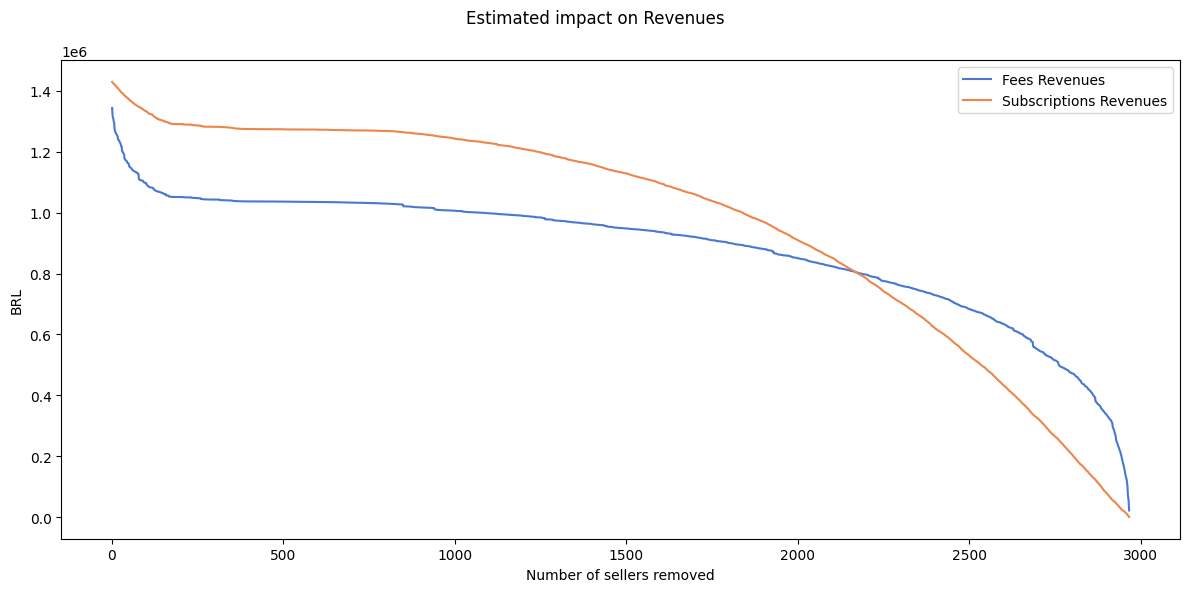

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Revenues")

profit_line = sns.lineplot(x=x,
                           y=fees_per_seller_removed,
                           label='Fees Revenues',
                           ax=ax)

revenue_line = sns.lineplot(x=x,
                            y=suscriptions_per_seller_removed,
                            label='Subscriptions Revenues',
                            ax=ax)

ax.set_xlabel('Number of sellers removed')
ax.set_ylabel('BRL')

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

#### IT Costs scaling parameters $\alpha$ and $\beta$

I know that the total IT Costs scale with both the number of sellers (`n_sellers`) and the amount of products they sold (`n_products`)  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  

- $\alpha = 3157.27$
- $\beta = 978.23$

In [16]:
alpha, beta = 3157.27, 978.23
n_sellers = sellers.shape[0]
n_products = sellers.quantity.sum()

In [17]:
def compute_costs_of_it(n_sellers, n_products):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_products)

In [18]:
new_n_sellers = n_sellers - np.arange(1, n_sellers, 1)
new_n_products = n_products - np.cumsum(sorted_sellers['quantity'][:-1])

it_costs_per_seller_removed = compute_costs_of_it(new_n_sellers, new_n_products)
review_costs_per_seller_removed = sellers['cost_of_reviews'].sum() - np.cumsum(sorted_sellers['cost_of_reviews'][:-1])

costs_per_seller_removed = it_costs_per_seller_removed + review_costs_per_seller_removed

#### Costs

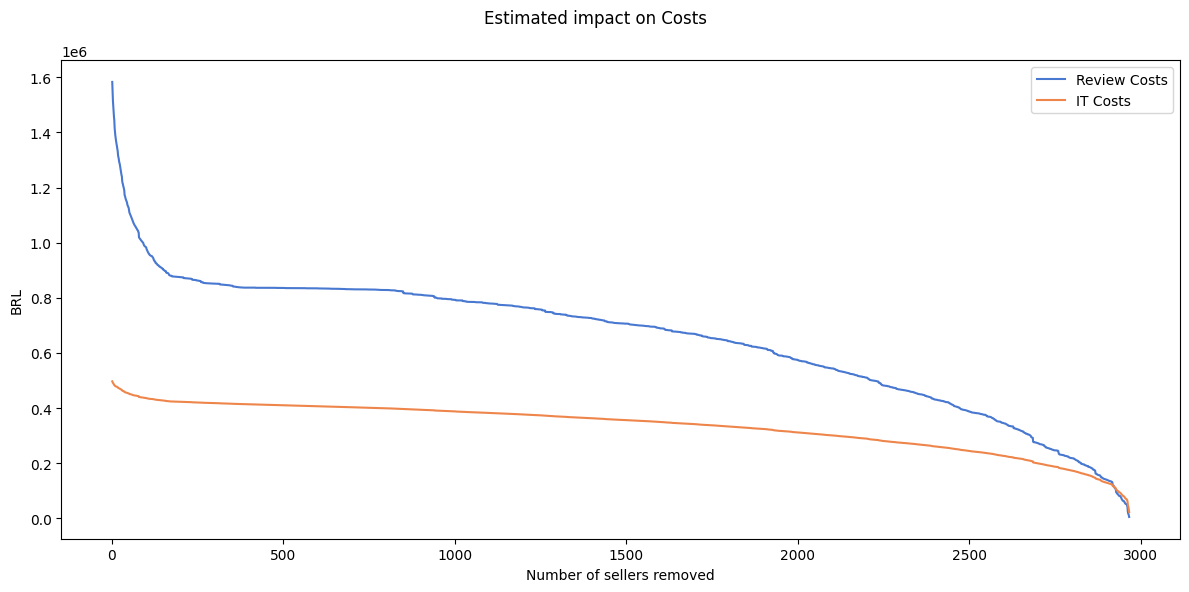

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Costs")

profit_line = sns.lineplot(x=x,
                           y=review_costs_per_seller_removed,
                           label='Review Costs',
                           ax=ax)

revenue_line = sns.lineplot(x=x,
                            y=it_costs_per_seller_removed,
                            label='IT Costs',
                            ax=ax)

ax.set_xlabel('Number of sellers removed')
ax.set_ylabel('BRL')

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

**👆 Removing the least profitable sellers nets a great decrease of the estimated costs of bad reviews**  
**👆 IT Costs seem less relevant to this analysis**

In [20]:
# Computing final metrics (profits and margin, for each scenario)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

### 3.3 How many under-performers to remove?

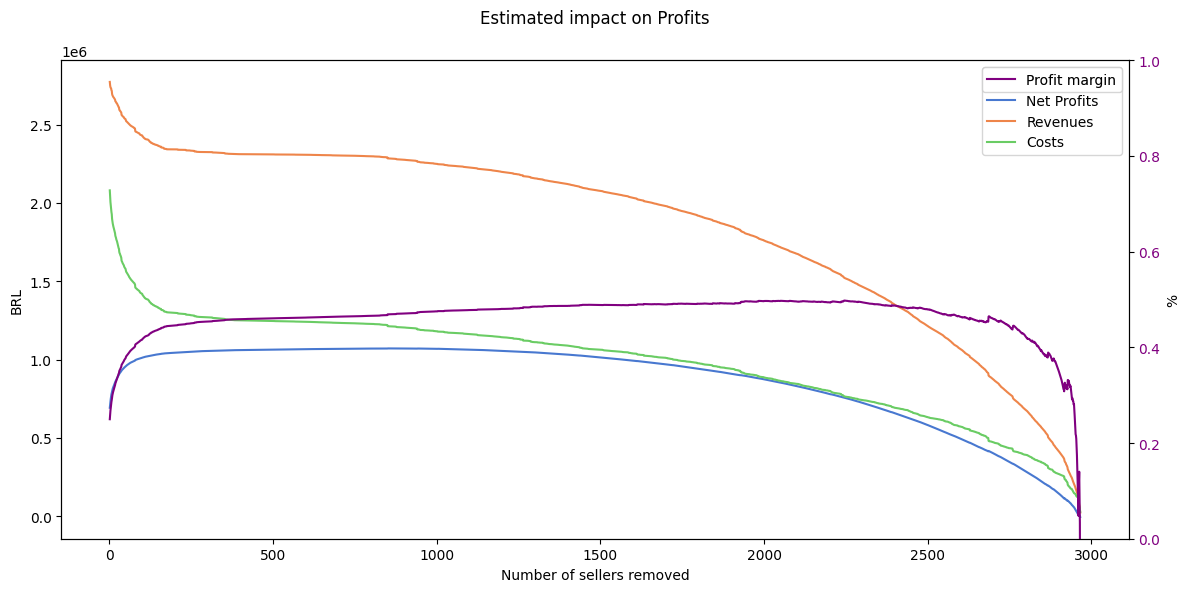

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

axs = [ax, ax.twinx()]

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Profits")

profit_line = sns.lineplot(x=x,
                           y=profits_per_seller_removed,
                           label='Net Profits',
                           ax=axs[0])

revenue_line = sns.lineplot(x=x,
                            y=revenues_per_seller_removed,
                            label='Revenues',
                            ax=axs[0])

costs_line = sns.lineplot(x=x,
                          y=costs_per_seller_removed,
                          label='Costs',
                          ax=axs[0])

axs[0].set_xlabel('Number of sellers removed')
axs[0].set_ylabel('BRL')

axs[0].tick_params(axis='y')

margin_line = sns.lineplot(x=x,
                           y=margin_per_seller_removed,
                           label='Profit margin',
                           color='purple',
                          ax=axs[1])

axs[1].set_ylabel('%')
axs[1].tick_params(axis='y',
                   labelcolor='purple')
axs[1].set(ylim=[0, 1])

lines = [axs[1].lines[0], *axs[0].lines]
labels = [line.get_label() for line in lines]
axs[0].legend(lines, labels)

fig.tight_layout()

In [22]:
# Find optimal number of sellers to remove
print(f"""
📊 Decision thresholds:

👉 Optimizing for profits requires removing {profits_per_seller_removed.argmax()} ({round(profits_per_seller_removed.argmax() / n_sellers * 100, 2)}%) sellers.
👉 Optimizing for profit margin requires removing {margin_per_seller_removed.argmax()} ({round(margin_per_seller_removed.argmax() / n_sellers * 100, 2)}%) sellers.
""")


📊 Decision thresholds:

👉 Optimizing for profits requires removing 854 (28.78%) sellers.
👉 Optimizing for profit margin requires removing 2244 (75.63%) sellers.



In [46]:
print(f'If Olist would have never let the 854 sellers join the platform, the impact on the profit would have been {round(100 / profits_net * profits_per_seller_removed[854], 2)}% higher than the current profit of {profits_net:.2f} BRL, at around {profits_net + profits_per_seller_removed[854]:.2f} BRL.')

If Olist would have never let the 854 sellers join the platform, the impact on the profit would have been 160.42% higher than the current profit of 667608.44 BRL, at around 1738584.56 BRL.


## 3. Investigate other Approaches 🕵️
WIP

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...
